In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d ananaymital/us-used-cars-dataset

100% 2.13G/2.13G [00:22<00:00, 54.7MB/s]
100% 2.13G/2.13G [00:22<00:00, 99.9MB/s]


In [6]:
! unzip /content/us-used-cars-dataset.zip

Archive:  /content/us-used-cars-dataset.zip
  inflating: used_cars_data.csv      


In [7]:
df = pd.read_csv('used_cars_data.csv' , nrows = 2000000 , usecols = ['back_legroom','body_type',
  'city', 'city_fuel_economy','daysonmarket',  'description','engine_displacement', 
  'engine_type', 'exterior_color', 'fleet' ,'franchise_dealer', 'franchise_make', 'front_legroom',
  'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
  'highway_fuel_economy', 'horsepower', 'isCab', 'is_new', 'latitude', 'length',
  'listed_date', 'listing_color', 'longitude','major_options', 'make_name', 'maximum_seating',
  'mileage', 'model_name', 'owner_count', 'price', 'salvage',
  'seller_rating', 'sp_name', 'theft_title', 'transmission_display',
  'trim_name','wheel_system_display', 'width', 'year'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 42 columns):
 #   Column                Dtype  
---  ------                -----  
 0   back_legroom          object 
 1   body_type             object 
 2   city                  object 
 3   city_fuel_economy     float64
 4   daysonmarket          int64  
 5   description           object 
 6   engine_displacement   float64
 7   engine_type           object 
 8   exterior_color        object 
 9   fleet                 object 
 10  franchise_dealer      bool   
 11  franchise_make        object 
 12  front_legroom         object 
 13  fuel_tank_volume      object 
 14  fuel_type             object 
 15  has_accidents         object 
 16  height                object 
 17  highway_fuel_economy  float64
 18  horsepower            float64
 19  isCab                 object 
 20  is_new                bool   
 21  latitude              float64
 22  length                object 
 23  listed_

##Data Preprocessing and Cleaning

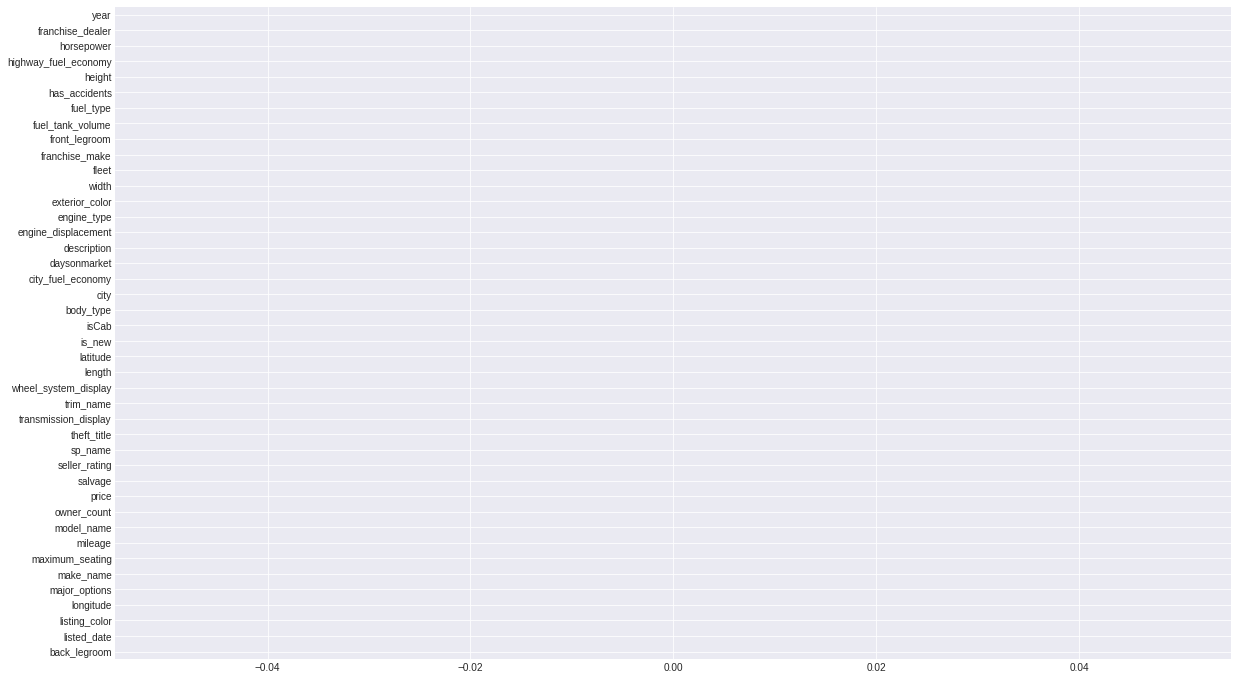

In [104]:
plt.style.use('seaborn-darkgrid')
(df.isnull().mean() * 100).sort_values(ascending = True).plot(kind = 'barh' , figsize = (20,12))

In [10]:
#  Using groupby fill for filling na values
oc_dict = df.groupby(['year'])['owner_count'].median().to_dict()
df['owner_count'] = df['owner_count'].fillna(df['year'].map(oc_dict))

nullsrs = (df.isnull().mean()*100).sort_values(ascending = False)
lst = nullsrs.loc[nullsrs > 40].index.to_list()
lst
for col in lst:
  df[col] = df[col].fillna(df[col].mode().values[0])


cfe = df.groupby(['city'])['city_fuel_economy'].median()
df['city_fuel_economy'] = df['city_fuel_economy'].fillna(df['city'].map(cfe.to_dict()))


hfe = df.groupby(['body_type'])['highway_fuel_economy'].median().to_dict()
df['highway_fuel_economy'] = df['highway_fuel_economy'].fillna(df['body_type'].map(hfe))

df['body_type'] = df['body_type'].fillna(df['body_type'].mode()[0])
df['mileage'] = df['mileage'].fillna(df['mileage'].mean())


# filling na values with mode & mean
nullsrs = (df.isnull().mean()*100).sort_values(ascending = False)
del_lst = nullsrs.loc[nullsrs < 7.5].index.to_list()
for col in df[del_lst].select_dtypes(['object']).columns.to_list():
  df[col] = df[col].fillna(df[col].mode()[0])
for col in df[del_lst].select_dtypes(['int64' , 'float64']).columns.to_list():
  df[col] = df[col].fillna(df[col].mean())


fm_df = df.groupby(['model_name'])['franchise_make']. \
                        agg(pd.Series.mode).explode(). \
                        to_frame().reset_index(). \
                        drop_duplicates('model_name' , keep = 'last')
for model in fm_df[fm_df['franchise_make'].isna()]['model_name'].values:
  df = df.drop(index = df[df['model_name'] == model].index)

df['franchise_make'] = df['franchise_make'].fillna(df['model_name'].map(fm_df.set_index('model_name').to_dict()['franchise_make']))

#  replacing '--' value in columns
for col in ['back_legroom' , 'front_legroom' , 'fuel_tank_volume' , 'length' , 'maximum_seating' , 'width' , 'height']:
  df[col]= df[col].replace( '--' , df[col].mode()[0] )
  df[col] = df[col].map(lambda x : str(x).split()[0]).astype('float')


In [12]:

# dropping cities with 0 city fuel economy
# nullcmil = cfe.loc[cfe.isna()].index
# drp_idx = []
# for c in (nullcmil.to_list()):
#   drp_idx.append(df.query(" city == '{}' ".format(c)).index.to_list())

# for idx in drp_idx:
#   df = df.drop(index = idx)

In [19]:
round( df.select_dtypes(['float' , 'int']).describe() , 2).T.style.background_gradient(cmap = 'Greens')

,count,mean,std,min,25%,50%,75%,max
back_legroom,1999164.000000,38.010000,3.010000,0.000000,36.300000,38.300000,39.700000,59.800000
city_fuel_economy,1999164.000000,22.070000,7.060000,7.000000,18.000000,21.000000,25.000000,127.000000
daysonmarket,1999164.000000,76.730000,111.070000,0.000000,14.000000,35.000000,82.000000,3599.000000
engine_displacement,1999164.000000,2957.460000,1296.780000,700.000000,2000.000000,2500.000000,3500.000000,8400.000000
front_legroom,1999164.000000,42.120000,1.500000,0.000000,41.000000,41.700000,43.000000,67.000000
fuel_tank_volume,1999164.000000,18.980000,5.450000,1.900000,14.800000,18.000000,22.000000,64.000000
height,1999164.000000,66.010000,7.270000,43.700000,58.500000,66.100000,69.900000,117.600000
highway_fuel_economy,1999164.000000,28.850000,6.720000,10.000000,24.000000,28.000000,33.000000,127.000000
horsepower,1999164.000000,246.910000,86.690000,55.000000,176.000000,246.910000,295.000000,1001.000000
latitude,1999164.000000,38.150000,5.210000,18.350000,34.960000,39.940000,41.870000,61.200000


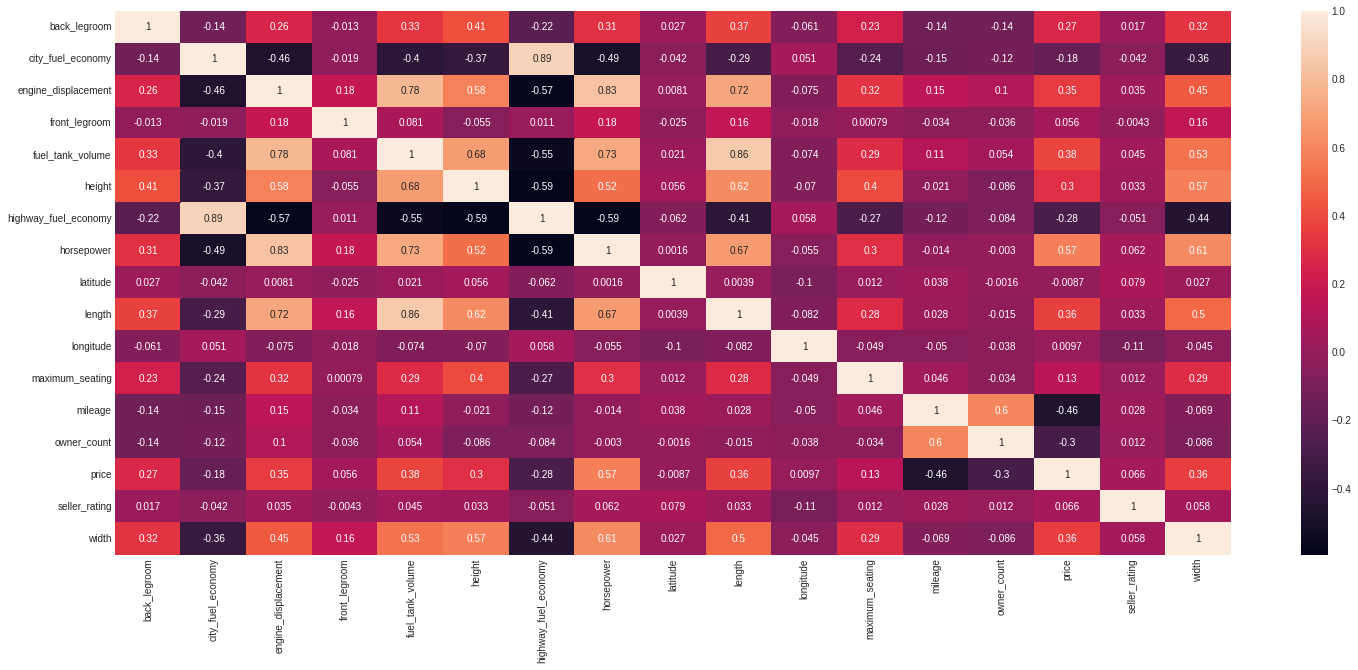

In [20]:
plt.figure(figsize = (25 , 10))
sb.heatmap(df.select_dtypes('float' , 'int').corr() , annot = True)

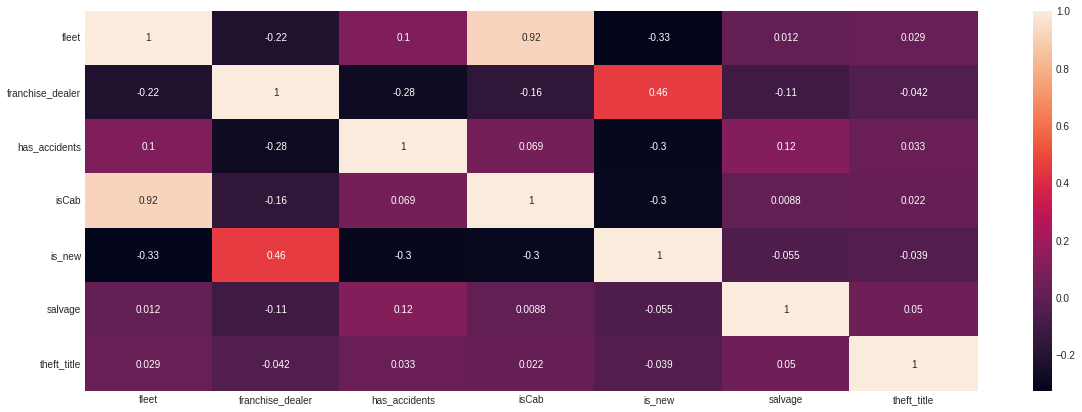

In [21]:
plt.figure(figsize = (20 , 7))
sb.heatmap(df.select_dtypes('bool').corr() , annot = True)

## Description of Numerical Attributes

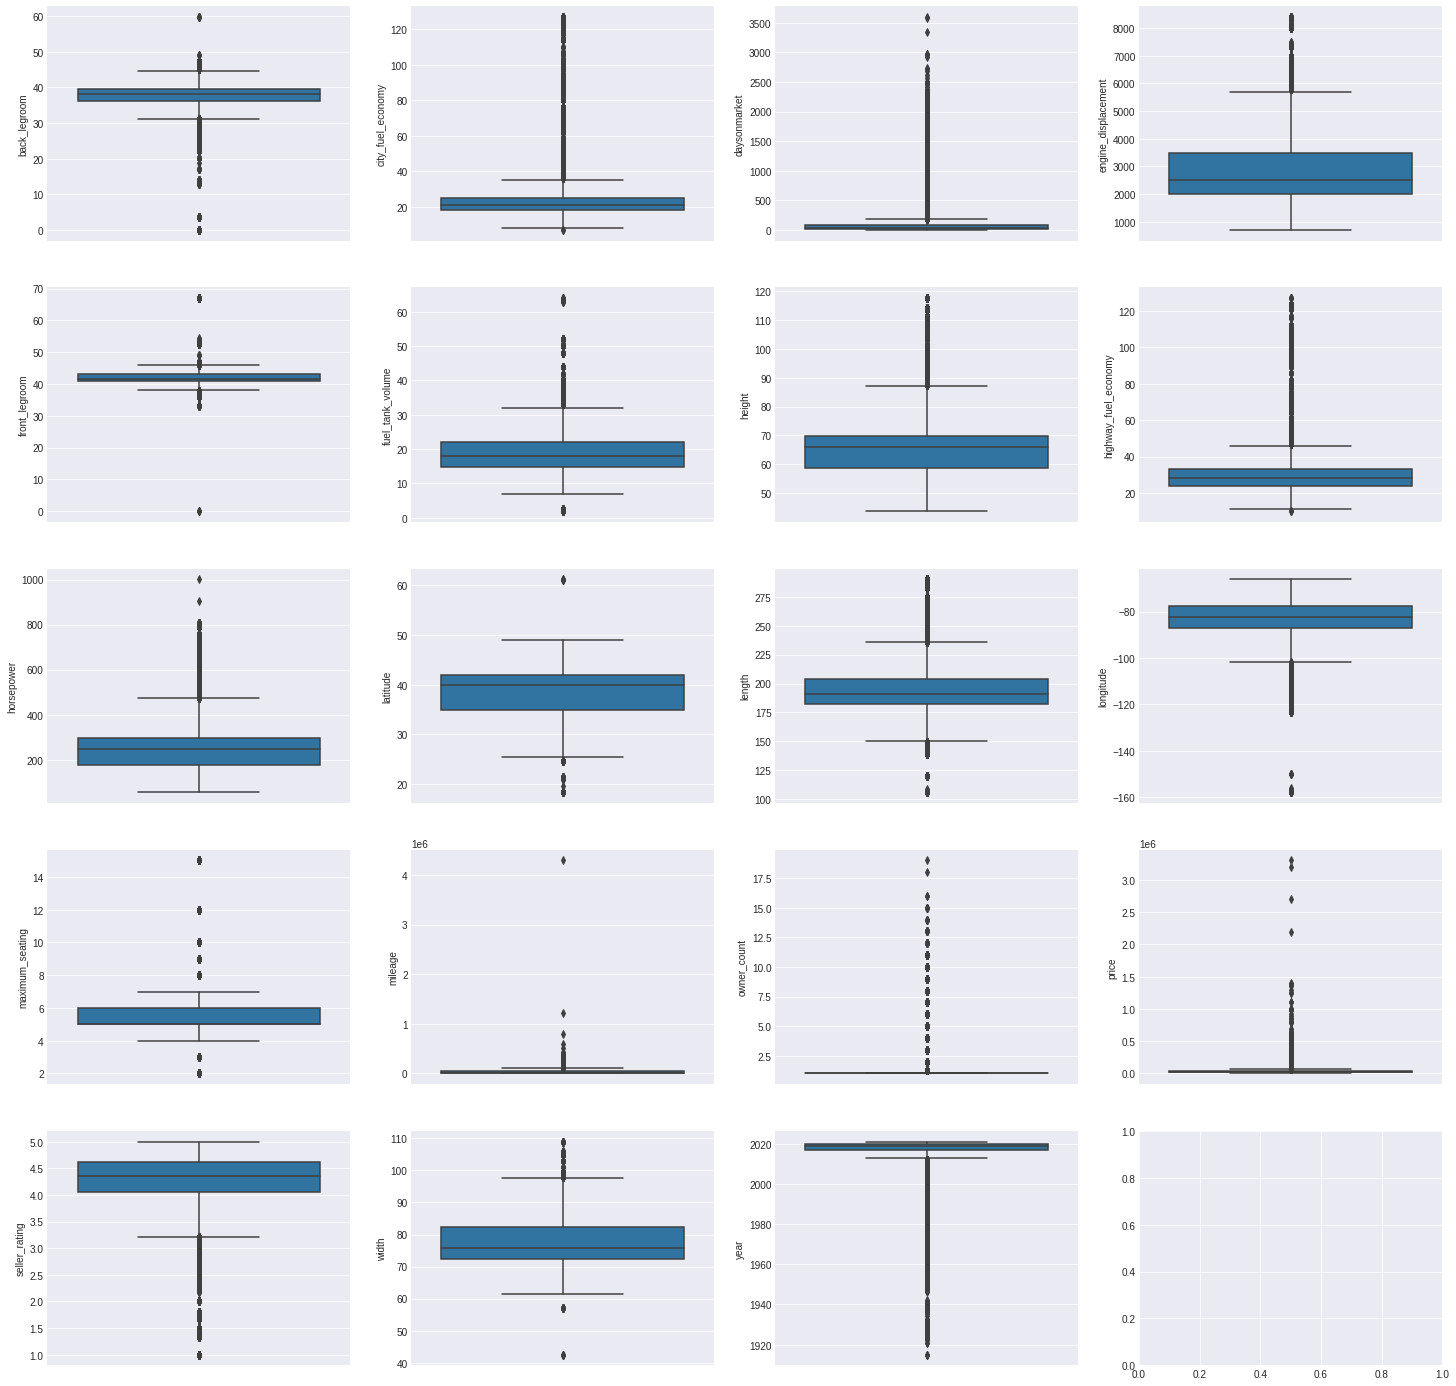

In [22]:
fig , ax = plt.subplots(nrows = 5 , ncols = 4 , figsize = (25,25))
ax = ax.ravel()
for i,col in enumerate(df.select_dtypes(['float' , 'int']).columns.to_list()):
  sb.boxplot(y = df[col] , ax = ax[i])

## Description of Boolean Attributes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

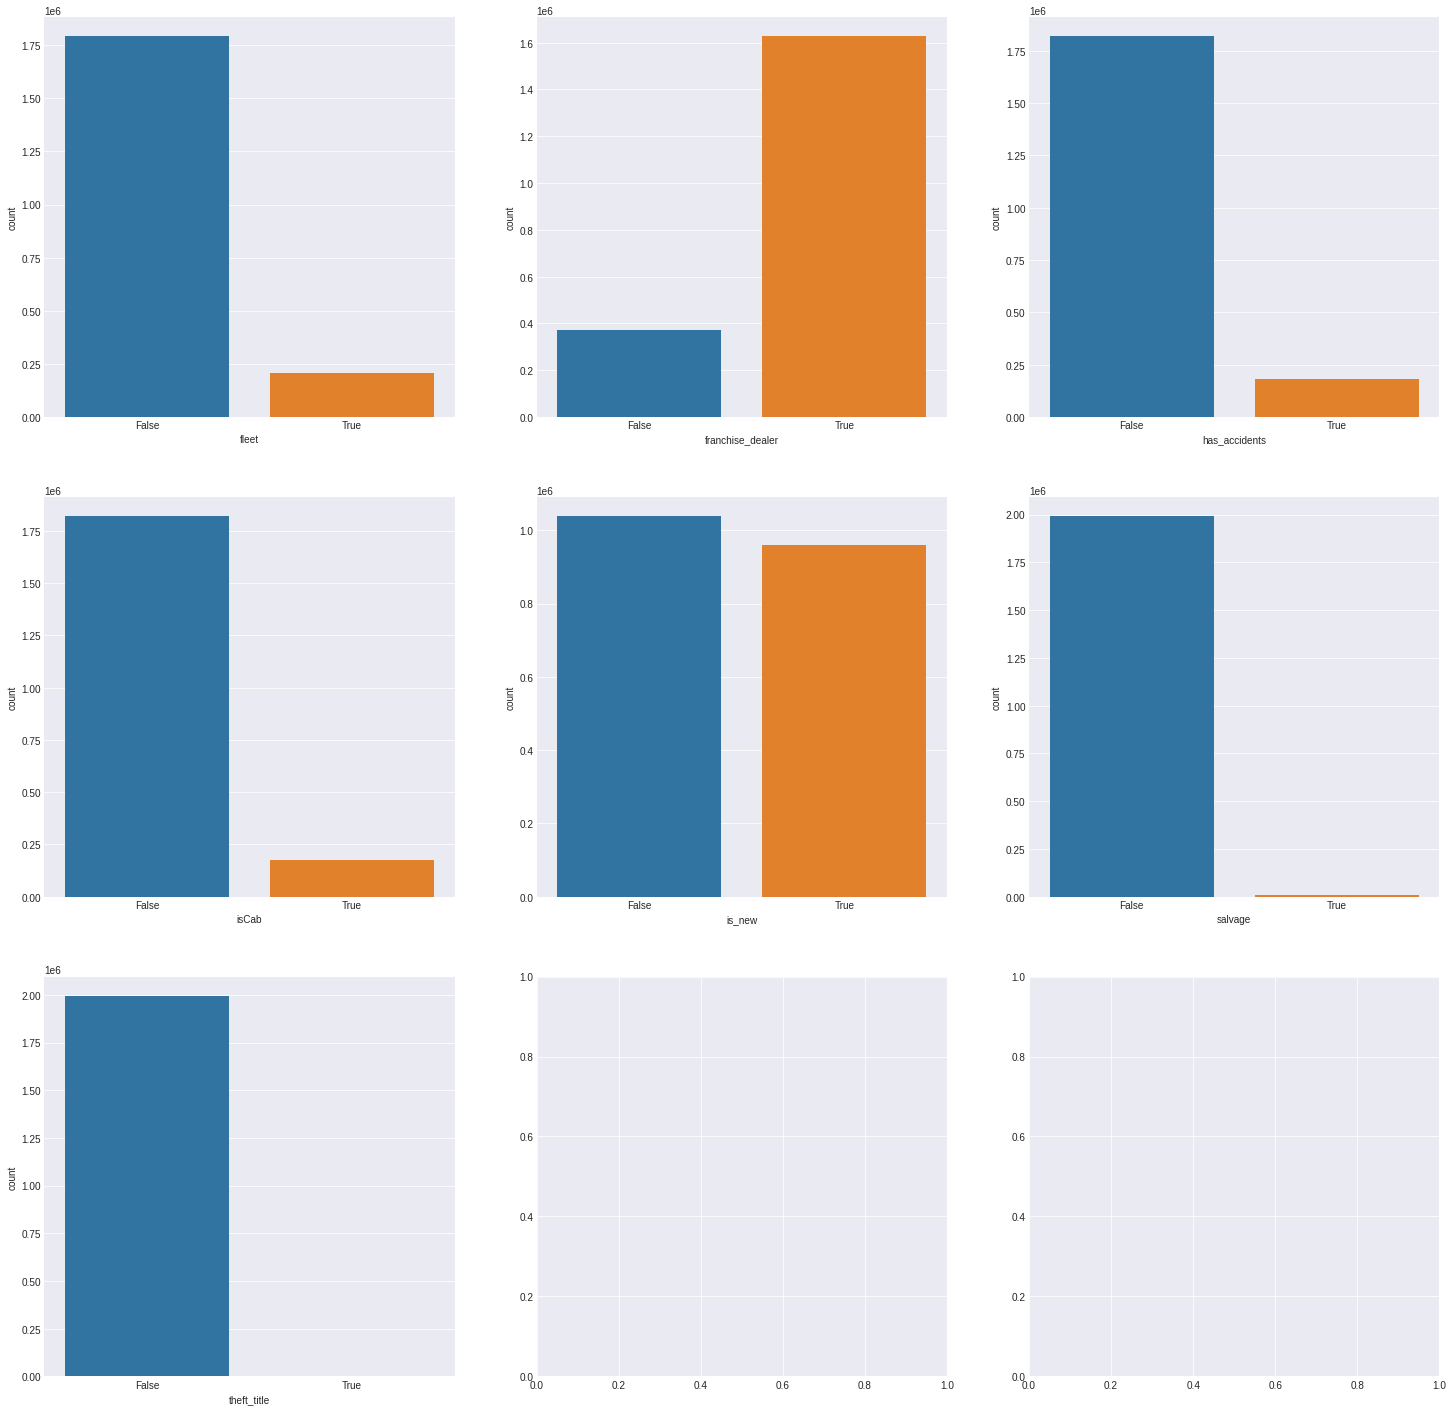

In [23]:
fig , ax = plt.subplots(nrows = 3 , ncols = 3 , figsize = (25,25))
ax = ax.ravel();
for i,col in enumerate(df.select_dtypes(['bool']).columns.to_list()):
  sb.countplot( df[col] , ax = ax[i]);

## Description of Nominal Attributes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

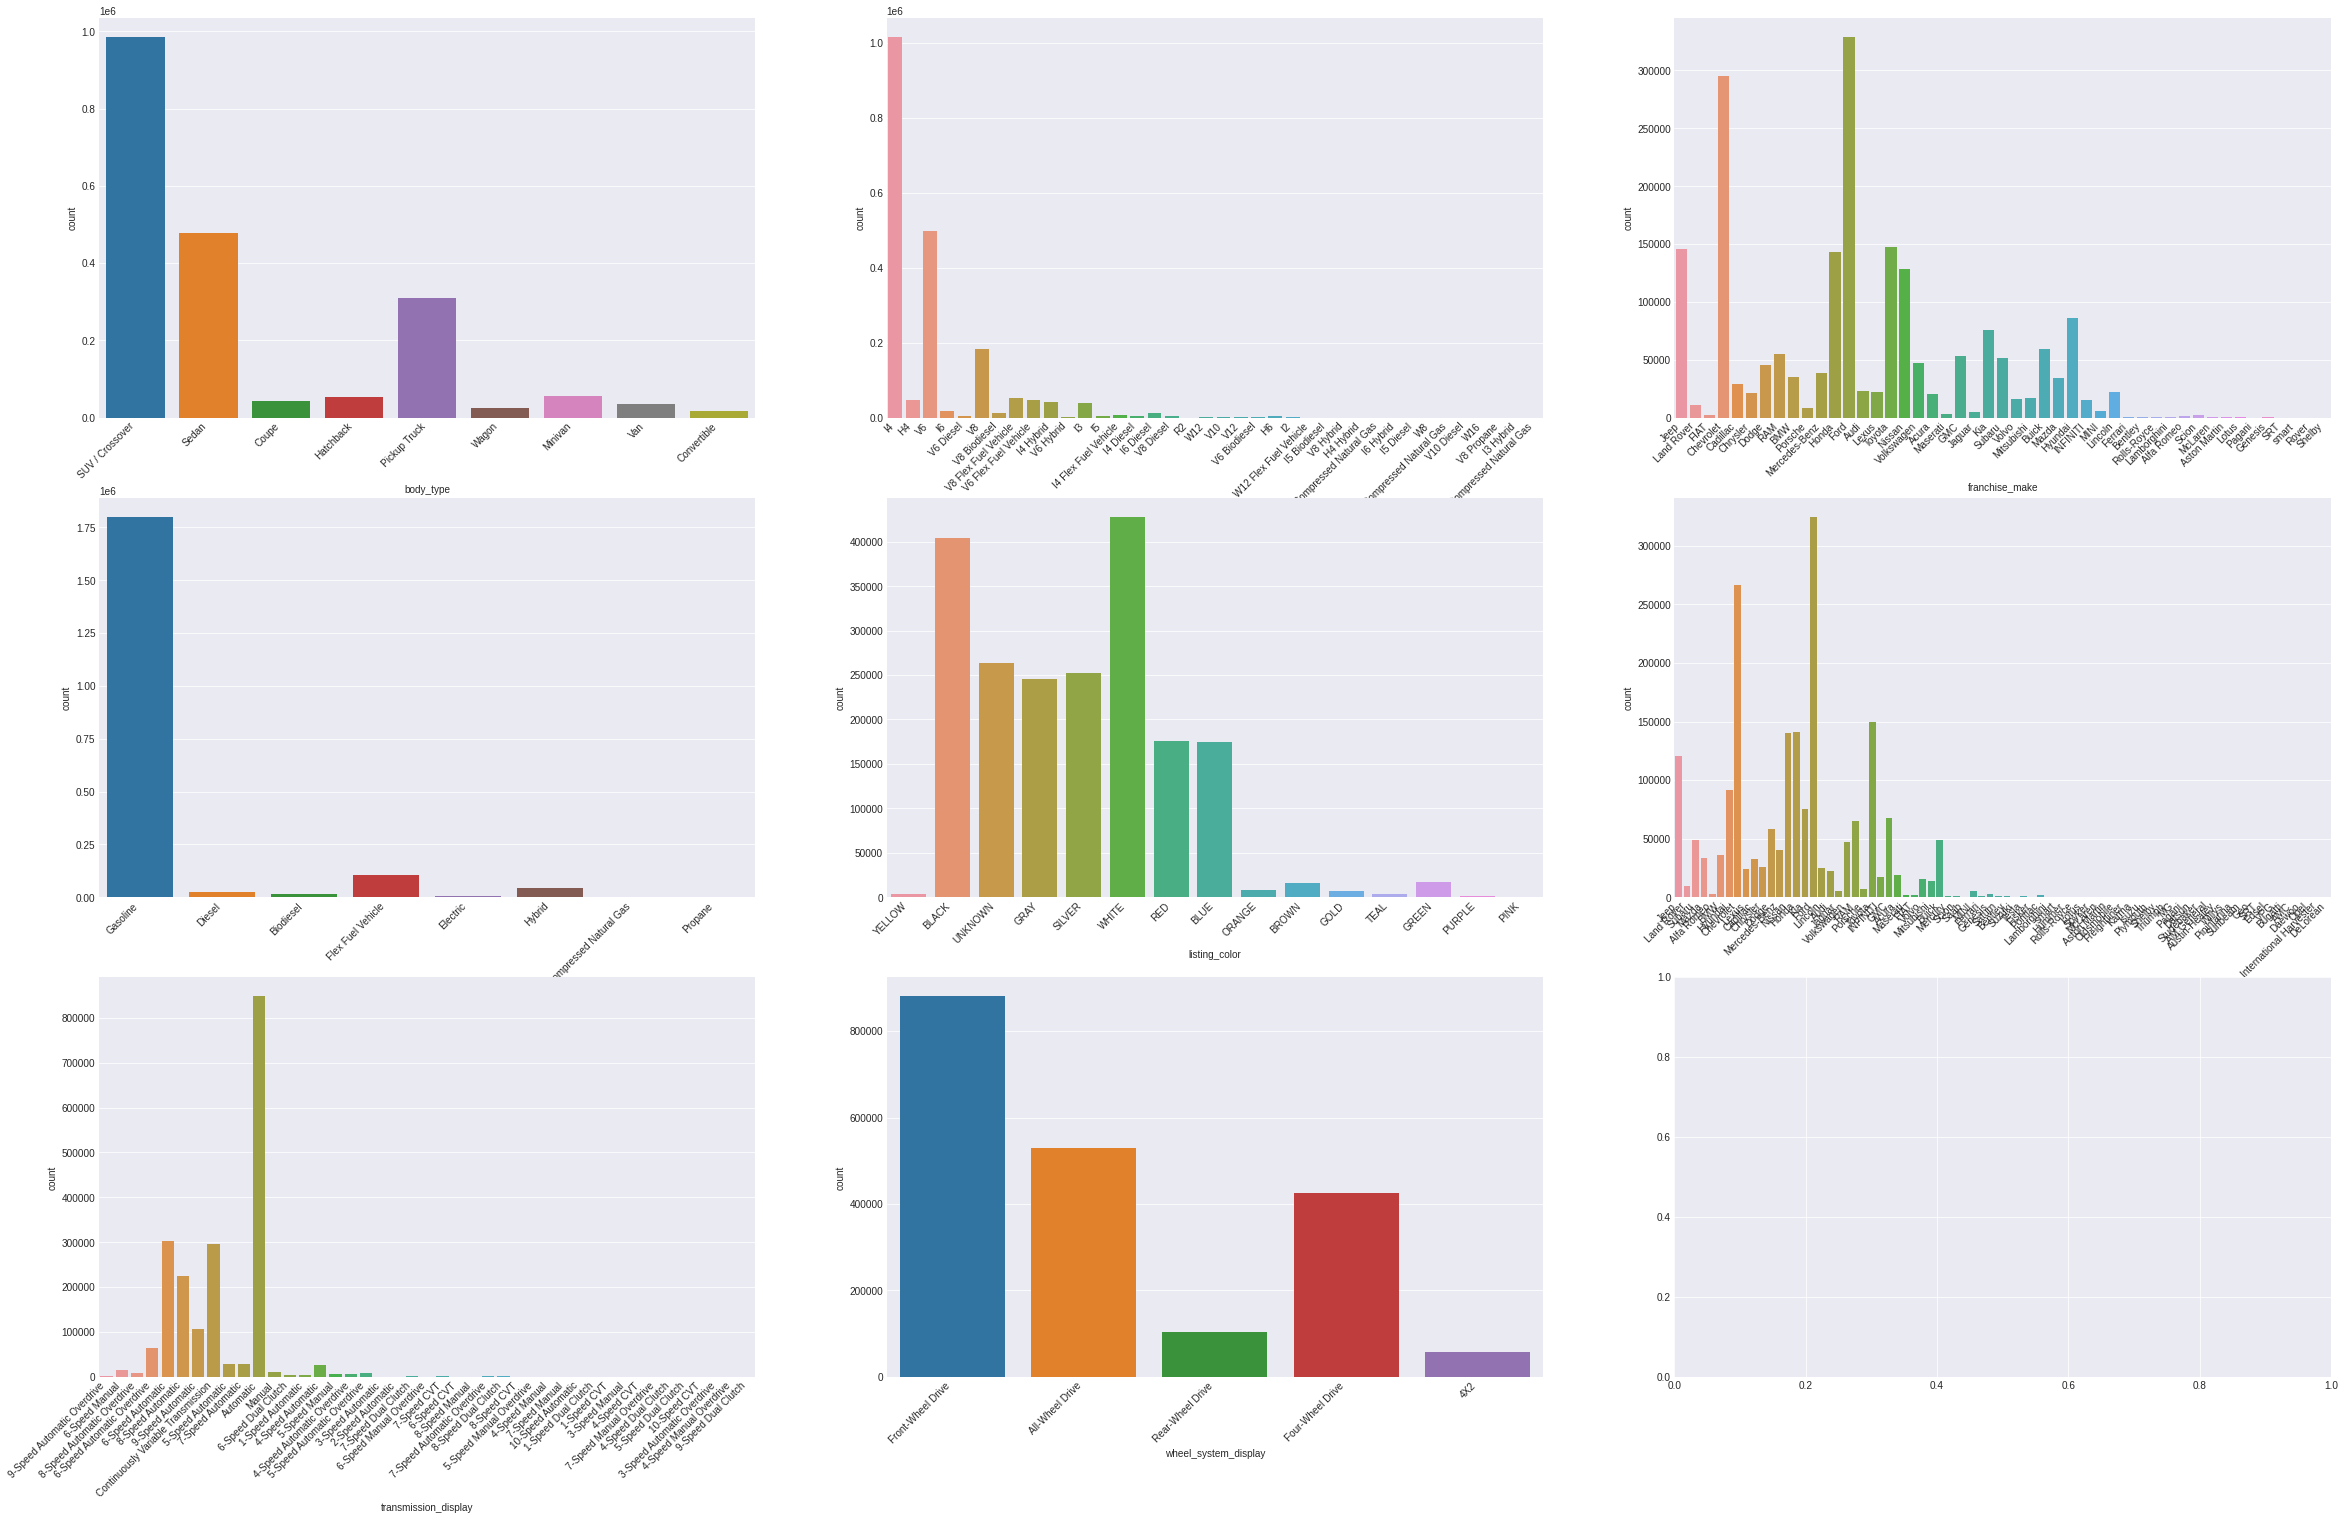

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [24]:
fig , ax = plt.subplots(nrows = 3 , ncols = 3 , figsize = (40 , 25))
ax = ax.ravel();
for i,col in enumerate(['body_type', 'engine_type', 'franchise_make', 'fuel_type', 'listing_color','make_name','transmission_display','wheel_system_display']):
  sb.countplot(df[col] , ax = ax[i]);
  plt.figure(figsize = (15,6));
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right');
plt.tight_layout()

In [25]:
analysisdf = df.query(' year >= 2000 and price <= 100000')

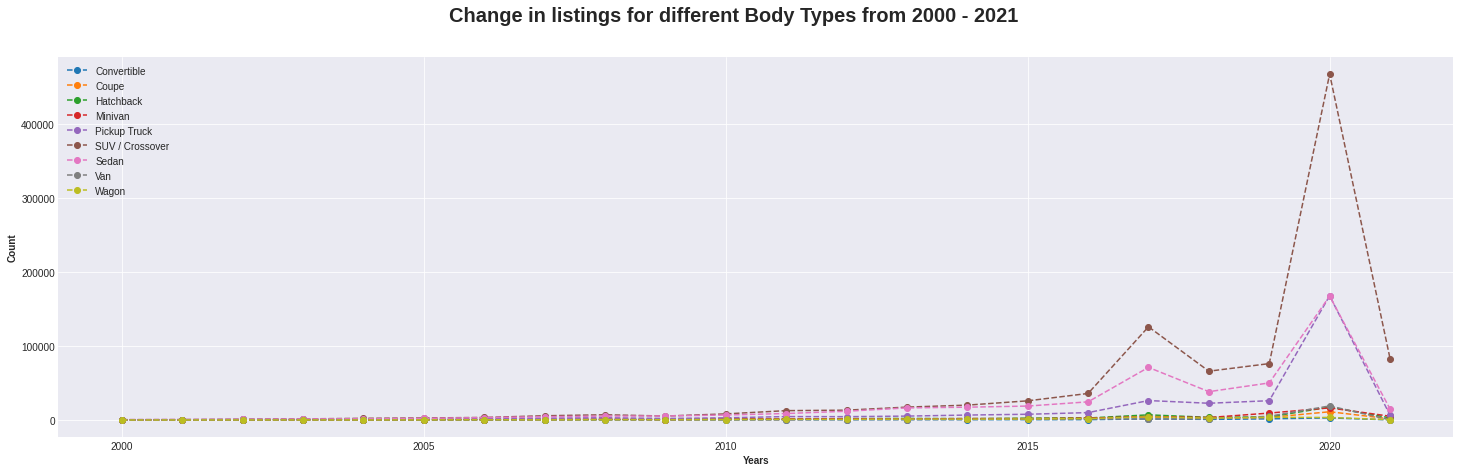

In [26]:
b = analysisdf.groupby(['body_type' , 'year'])['body_type'].count().unstack().fillna(0)
plt.figure(figsize = (25 , 7))
plt.suptitle('Change in listings for different Body Types from 2000 - 2021' , weight = 'bold'  , fontsize  = 20)
for btype in b.index:
    plt.plot( range(2000,2022) , b.loc[btype , : ] ,  marker = 'o'  , linestyle = '--' , label = btype)
plt.xlabel('Years' , weight = 'bold')
plt.ylabel('Count' , weight = 'bold')
plt.legend()

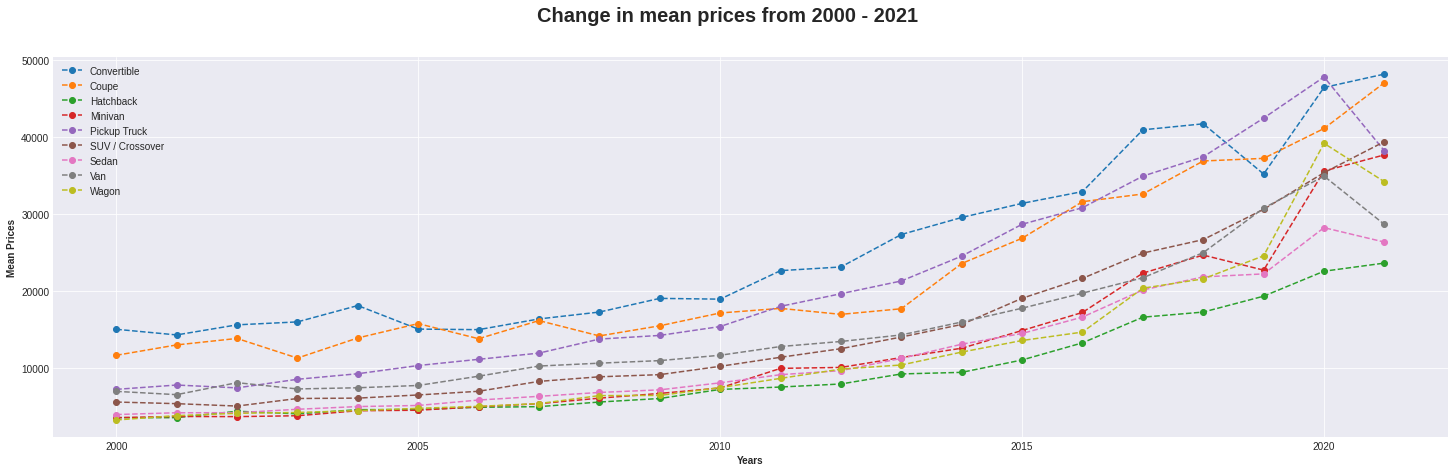

In [27]:
a = analysisdf.groupby(['body_type' , 'year'])['price'].mean().unstack().fillna(0)
plt.figure(figsize = (25 , 7))
plt.suptitle('Change in mean prices from 2000 - 2021' , weight = 'bold'  , fontsize  = 20)
for btype in a.index:
  plt.plot( range(2000,2022) , a.loc[btype , : ] ,  marker = 'o'  , linestyle = '--' , label = btype)
plt.xlabel('Years' , weight = 'bold')
plt.ylabel('Mean Prices' , weight = 'bold')
plt.legend()

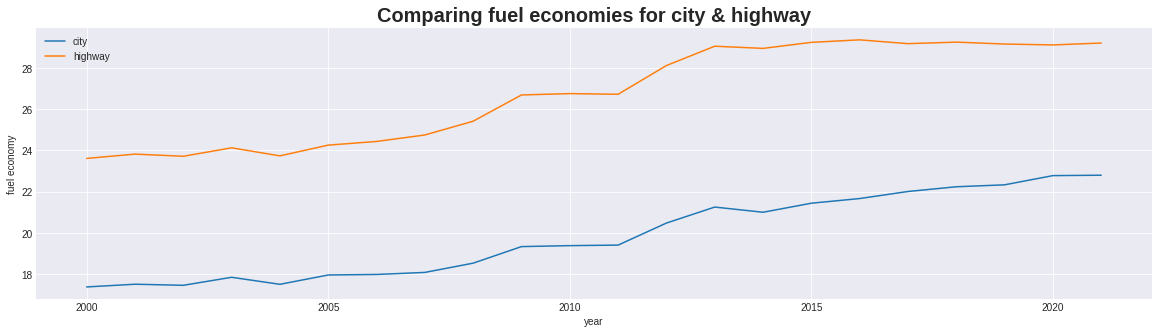

In [79]:
cityfe = analysisdf.groupby(['year'])['city_fuel_economy'].mean()
highwayfe = analysisdf.groupby(['year'])['highway_fuel_economy'].mean()
plt.figure(figsize = (20,5))
plt.title('Comparing fuel economies for city & highway' , weight = 'bold', fontsize = 20)
plt.plot(range(2000,2022) , cityfe.values , label = 'city')
plt.plot(range(2000,2022) , highwayfe.values , label = 'highway')
plt.xlabel('year')
plt.ylabel('fuel economy')
plt.legend()

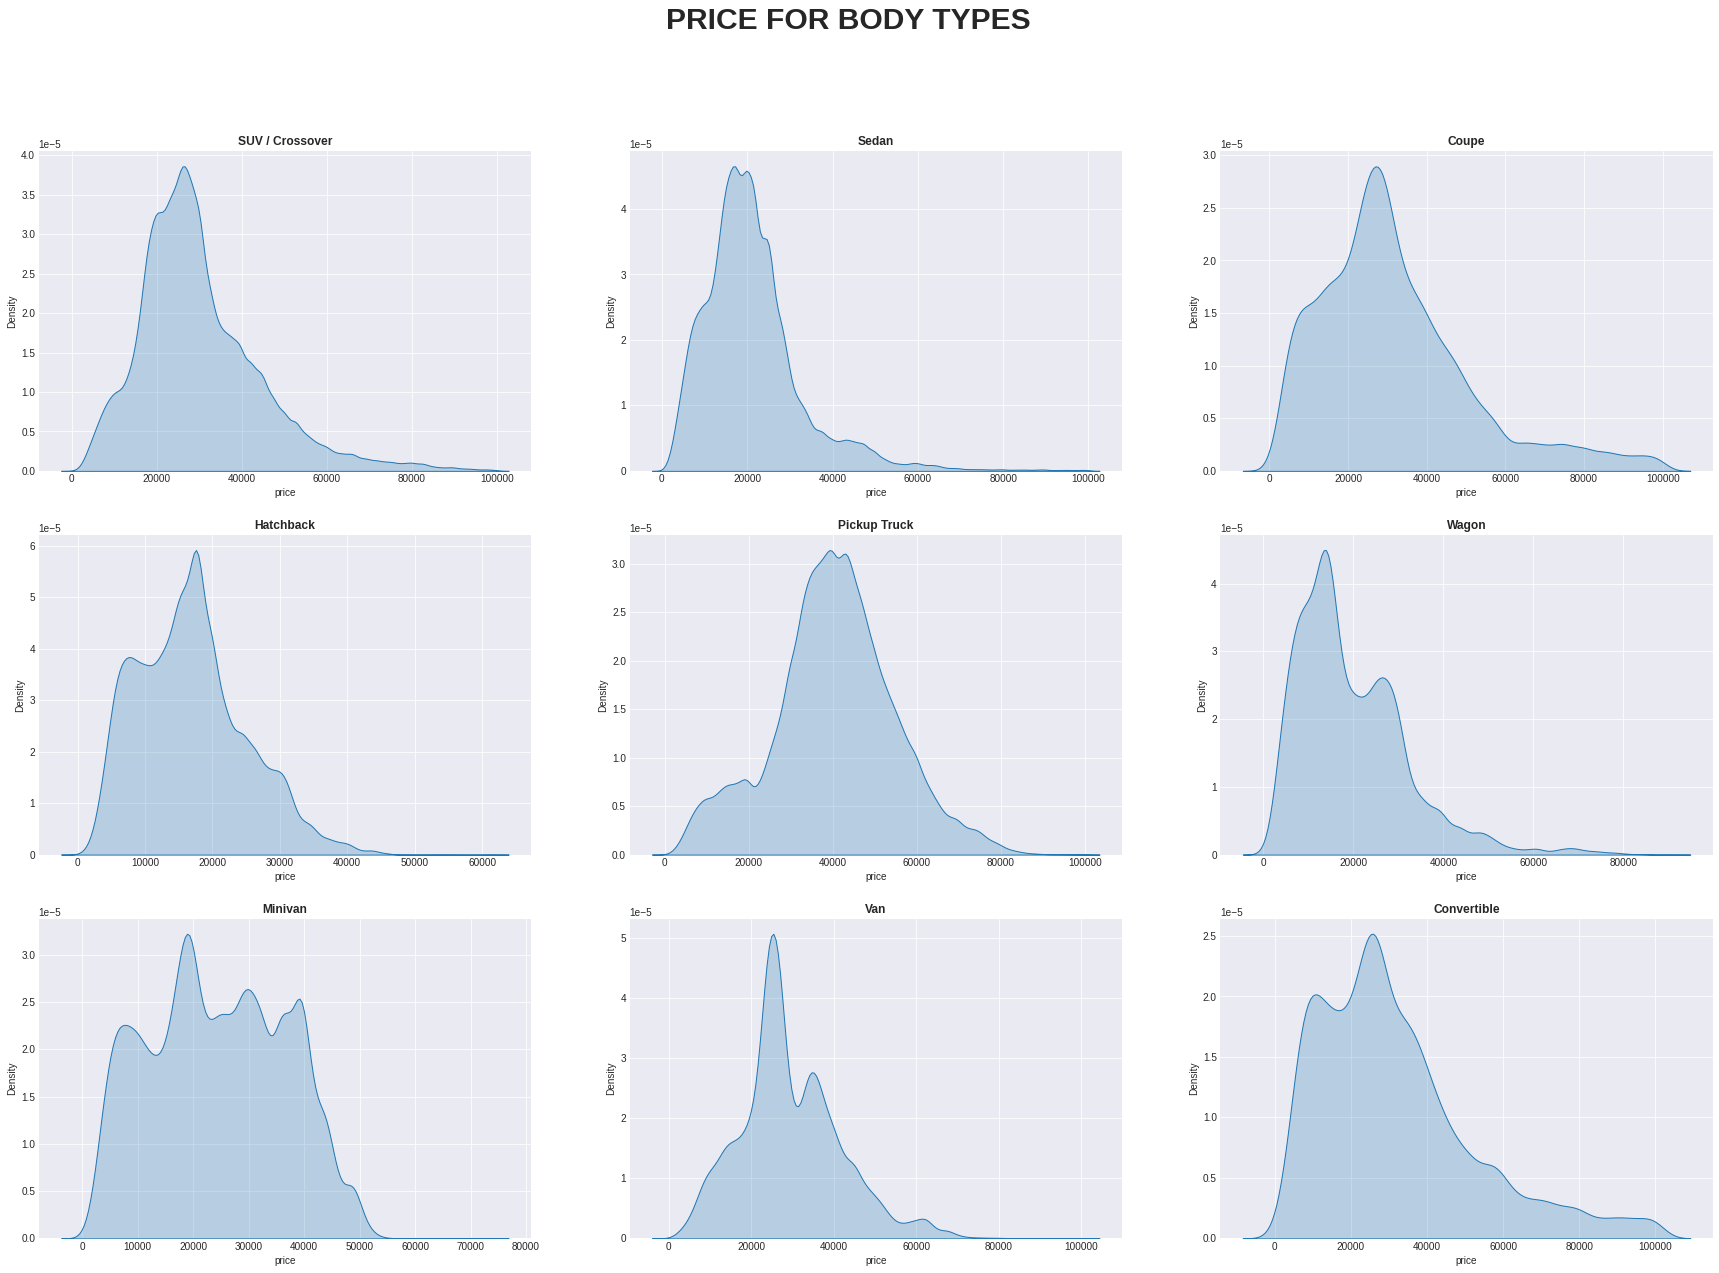

In [78]:
lst = list(analysisdf['body_type'].unique())
fig , ax = plt.subplots(nrows = 3 , ncols = 3 , figsize = (30 , 20))
ax = ax.ravel()
plt.suptitle('PRICE FOR BODY TYPES' , weight = 'bold' , fontsize = 20)
for i,typ in enumerate(lst):
  ax[i].set_title(typ , weight = 'bold')
  sb.kdeplot(analysisdf.query(" body_type == @typ " )['price'] , shade = 'fill' , ax = ax[i])

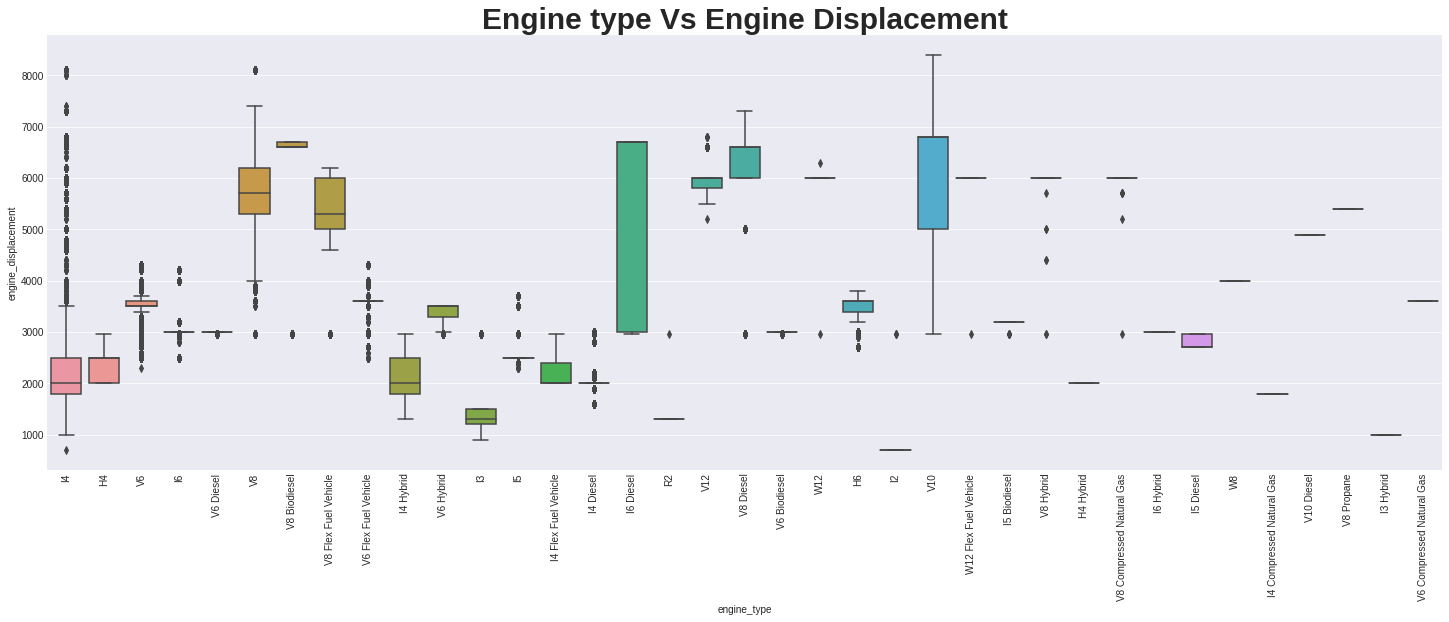

In [77]:
plt.figure(figsize = (25,8));
plt.title('Engine type Vs Engine Displacement' , weight = 'bold', fontsize = 20)
sb.boxplot(x = 'engine_type', y = 'engine_displacement', data = analysisdf);
plt.xticks(rotation = 90);

## Engine types across different categories

In [31]:
lst1 = list(analysisdf['engine_type'].map( lambda x : x.split()[-1] if len(x.split()) > 1 else x).unique())
for i in range(len(lst1)):
  if ( list(lst1[i])[-1].isnumeric() == False ):
    display(analysisdf[analysisdf['engine_type'].
           map(lambda x : x.endswith(lst1[i]))]['engine_type'].\
           value_counts(). \
           to_frame().reset_index(). \
           rename(columns = {'index' : 'engine_type' , 'engine_type':'count'}) \
           .style.set_caption(" Category : {} ".format(lst1[i])))
    print('\n\n')
  else:
    continue        

,engine_type,count
0,I6 Diesel,12891
1,I4 Diesel,4652
2,V6 Diesel,3979
3,V8 Diesel,3949
4,I5 Diesel,21
5,V10 Diesel,2


,engine_type,count
0,V8 Biodiesel,12726
1,V6 Biodiesel,2168
2,I5 Biodiesel,69


,engine_type,count
0,V8 Flex Fuel Vehicle,52915
1,V6 Flex Fuel Vehicle,47811
2,I4 Flex Fuel Vehicle,6218
3,W12 Flex Fuel Vehicle,49


,engine_type,count
0,I4 Hybrid,40581
1,V6 Hybrid,1707
2,V8 Hybrid,84
3,H4 Hybrid,71
4,I6 Hybrid,7
5,I3 Hybrid,1


,engine_type,count
0,V8 Compressed Natural Gas,63
1,I4 Compressed Natural Gas,12
2,V6 Compressed Natural Gas,1


,engine_type,count
0,V8 Propane,5


Text(0.5, 1.0, 'Body types with different engine types')

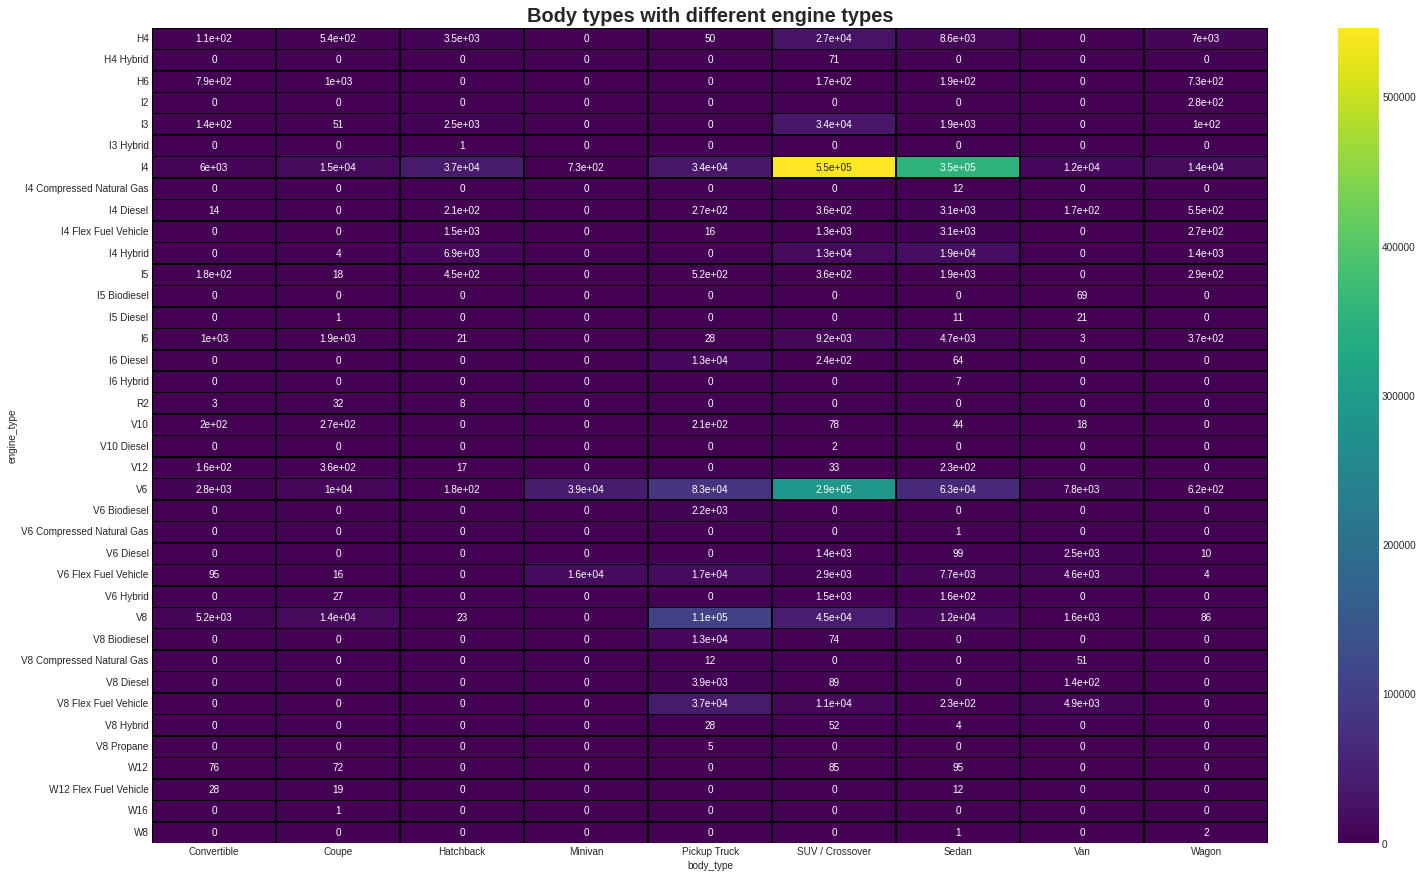

In [89]:
plt.figure(figsize = (25,15))
sb.heatmap(df.groupby(['engine_type' , 'body_type'])['body_type'].count().unstack().fillna(0).astype('int') ,  \
           annot = True  , linewidth = 0.5 , linecolor = 'black' , cmap ='viridis')
plt.title('Body types with different engine types' , weight = 'bold' , fontsize = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


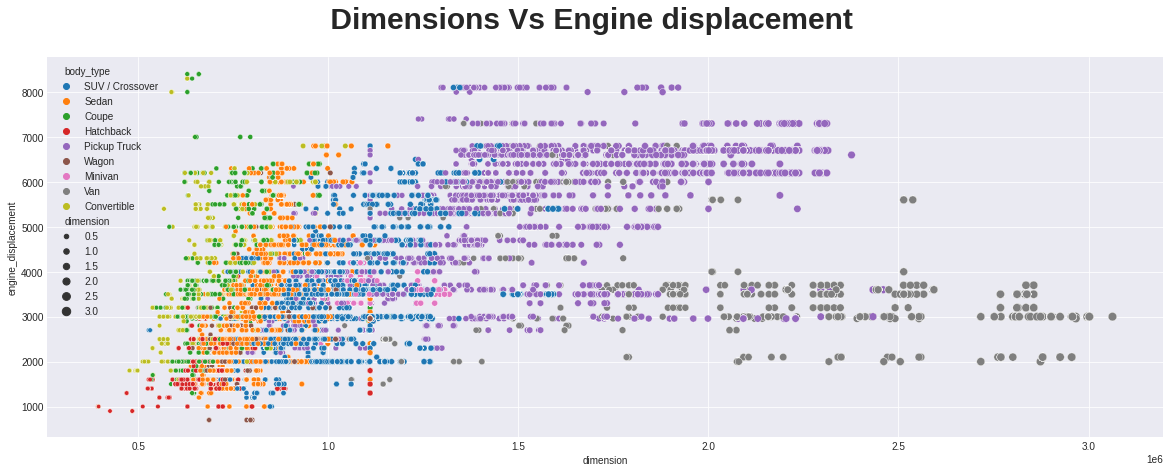

In [76]:
veh_dim = analysisdf[['length' ]].values * analysisdf[['width']].values * analysisdf[['height']].values
analysisdf['dimension'] = veh_dim
plt.figure(figsize = (20,7));
plt.suptitle(' Dimensions Vs Engine displacement' , weight = 'bold', fontsize = 20);
sb.scatterplot(x ='dimension' , y = 'engine_displacement' , hue = 'body_type' , size = 'dimension' , data = analysisdf);

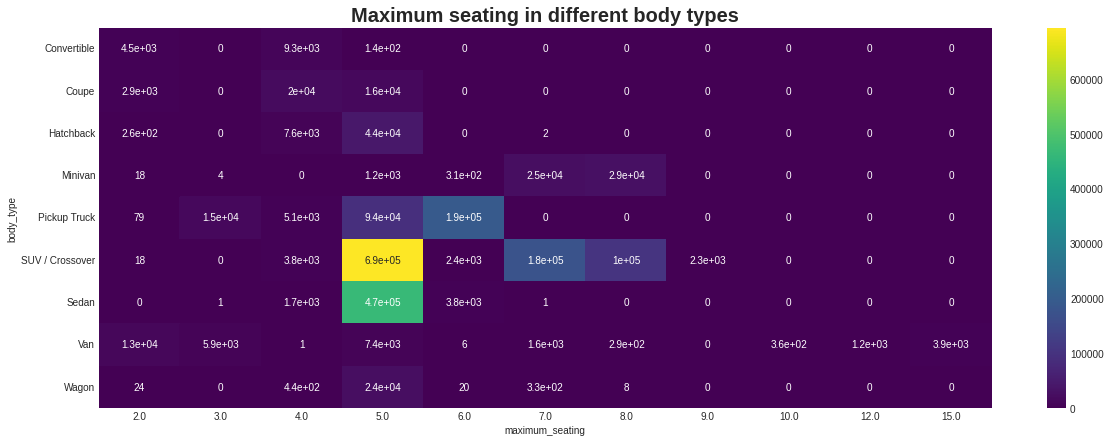

In [80]:
plt.figure(figsize = (20,7))
plt.title('Maximum seating in different body types' , weight = 'bold', fontsize = 20)
sb.heatmap(pd.crosstab(index = analysisdf['body_type'] ,  \
            columns = analysisdf['maximum_seating'] , \
            values = analysisdf['maximum_seating'] , \
            aggfunc = ('count')).fillna(0)  , annot = True, cmap = 'viridis')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


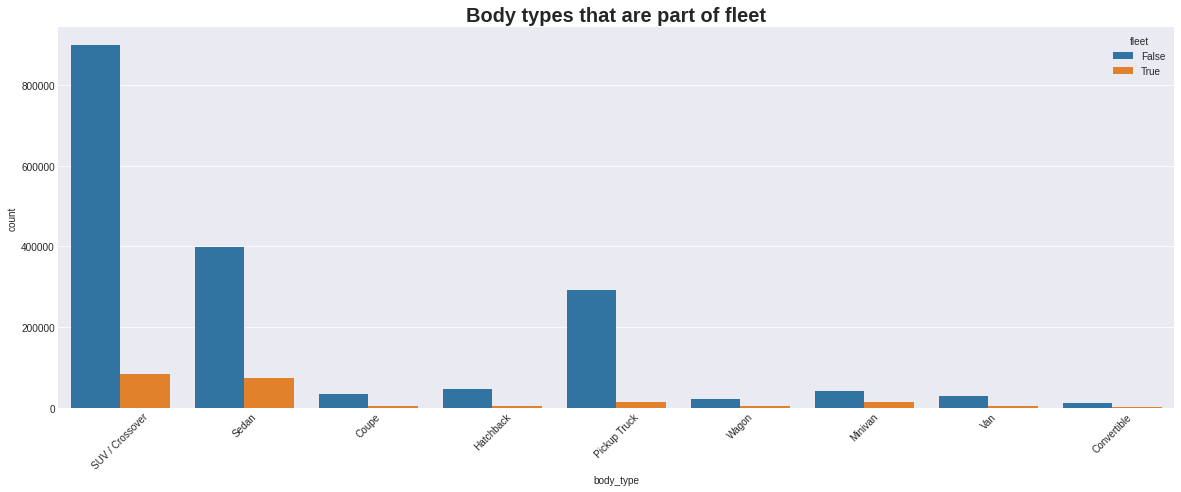

In [84]:
plt.figure(figsize = (20,7))
sb.countplot('body_type' , hue = 'fleet' , data = analysisdf);
plt.title('Body types that are part of fleet' , weight = 'bold', fontsize = 20);
plt.xticks(rotation = 45);

Text(0.5, 0, 'manufacturers')

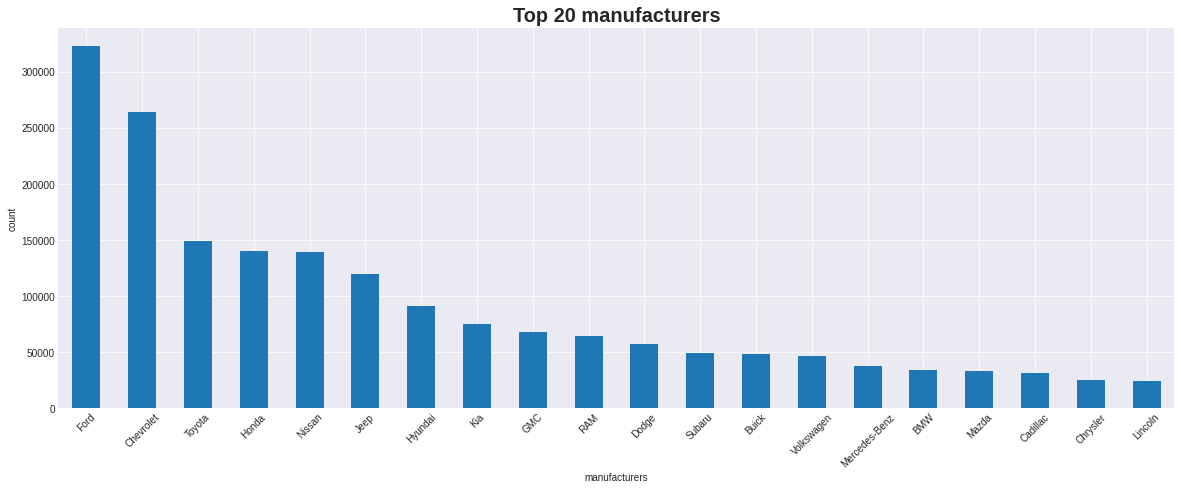

In [83]:
# Top 20 manufacturers
analysisdf['make_name'].value_counts().sort_values(ascending = False) \
.head(20).plot(kind = 'bar', rot = 45 ,figsize = (20,7))
plt.title('Top 20 manufacturers' , weight = 'bold' , fontsize = 20)
plt.ylabel('count')
plt.xlabel('manufacturers')

Text(0.5, 0, 'manufacturers')

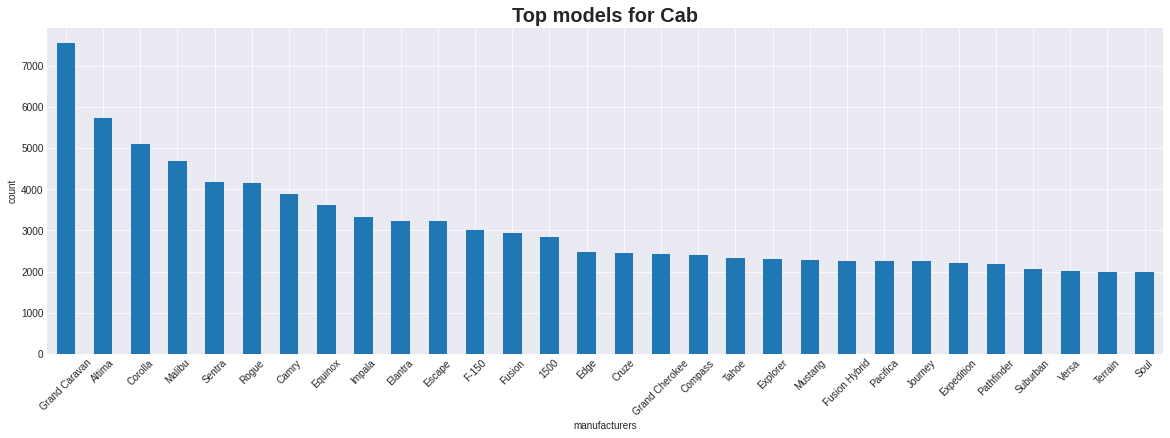

In [82]:
plt.figure(figsize = (20,6))
analysisdf.query( "isCab == {} ".format(1) )['model_name'] \
                      .value_counts().head(30) \
                      .plot(kind = 'bar' ,rot = 45)
plt.title('Top models for Cab' , weight = 'bold', fontsize = 20)
plt.ylabel('count')
plt.xlabel('manufacturers')

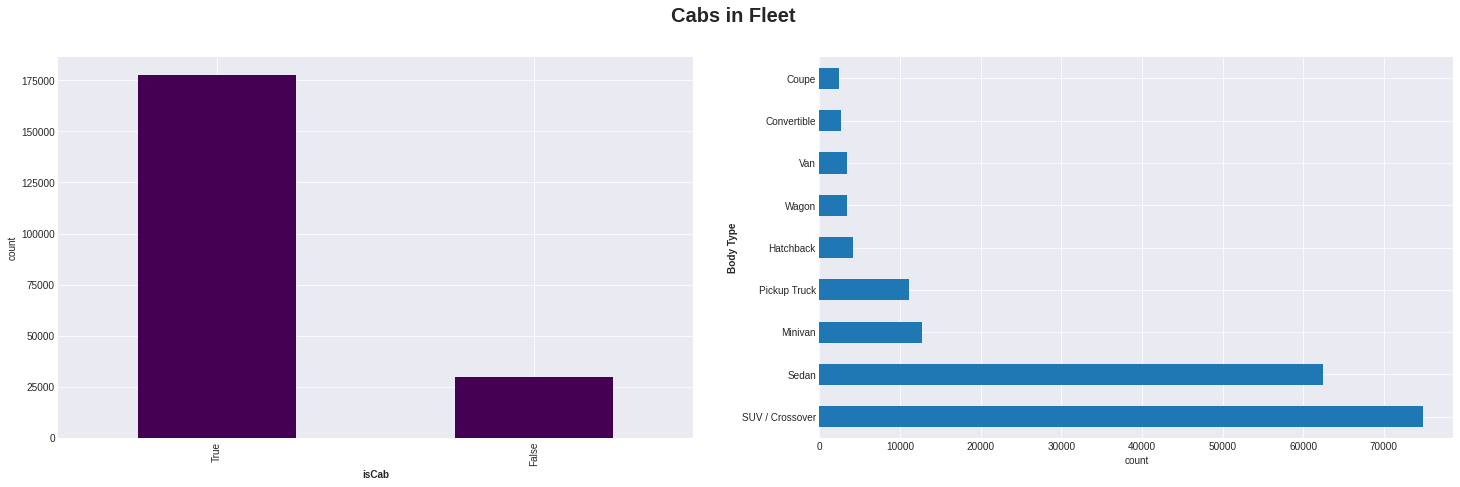

In [81]:
plt.suptitle('Cabs in Fleet' , weight = 'bold' , fontsize = 20)
plt.subplot(121)
analysisdf.query('fleet == {}'.format(1))['isCab'].value_counts().plot(kind = 'bar' , cmap = 'viridis' , figsize = (20,7))
plt.xlabel('isCab' , weight ='bold')
plt.ylabel('count')

plt.subplot(122)
fc_df = analysisdf.query('fleet == {} & isCab == {}'.format(1,1))['body_type'].value_counts()
fc_df.plot(kind = 'barh' , figsize = (25,7))
plt.xlabel('count')
plt.ylabel('Body Type' , weight = 'bold');

In [99]:
import plotly.express as px
theftdf = analysisdf.query('theft_title == {}'.format(1))['city'].value_counts().to_frame().reset_index().rename(columns = {'index':'city' , 'city':'count'})
fig = px.bar(theftdf.query('count >= 10'), x='city', y='count')
fig.show()

In [103]:
salvagedf = analysisdf.query('salvage == {}'.format(1))['city'].value_counts().to_frame().reset_index().rename(columns = {'index':'city' , 'city':'count'})
fig = px.bar(salvagedf.query('count >= 50'), x='city', y='count')
fig.show()